In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from variational_distributions import MeanFieldV1, MeanFieldV2
from advi import ADVI_V2
from metrics import kl_divergence
from init import initialize
import tensorflow_probability.substrates.jax as tfp
import distrax
import optax
from time import time

dist = tfp.distributions

## V1 (coin toss)

### Simulate data

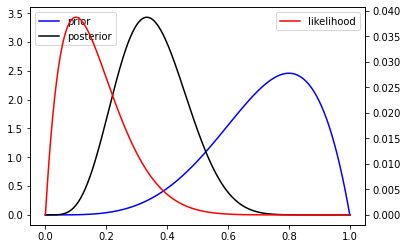

In [2]:
N = 10
n_heads = 1
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
a = 5.0
b = 2.0

gt_prior_dist = dist.Beta(concentration1=a, concentration0=b)
theta = gt_prior_dist.sample(seed=key)
tosses = jnp.array([1] * n_heads + [0] * (N - n_heads))
n_heads = jnp.sum(tosses)
gt_posterior_dist = dist.Beta(a + n_heads, b + N - n_heads)

theta_range = jnp.linspace(0.0, 1.0, 1000)

plt.plot(theta_range, gt_prior_dist.prob(theta_range), color="b", label="prior")
plt.plot(theta_range, gt_posterior_dist.prob(theta_range), color="k", label="posterior")
plt.legend(loc="upper left")

likelihood_fun = jax.jit(jax.vmap(lambda x: jnp.exp(jnp.sum(dist.Bernoulli(probs=x).log_prob(tosses)))))
plt.gca().twinx().plot(theta_range, likelihood_fun(theta_range), label="likelihood", color="r")

plt.legend();

### Model definition

In [3]:
def likelihood_log_prob_fun(sample, data):
    return jnp.sum(dist.Bernoulli(probs=sample).log_prob(data))


variational_distribution = MeanFieldV2(transformation=distrax.Sigmoid())
model = ADVI_V2(
    prior_dist=gt_prior_dist,
    likelihood_log_prob_fun=likelihood_log_prob_fun,
    bijector=distrax.Sigmoid(),
    data=tosses,
)

### Training

7.564189195632935


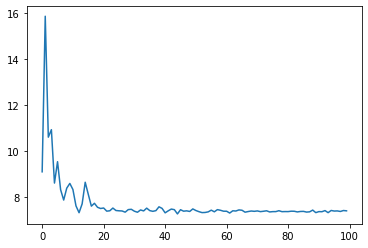

In [4]:
key = jax.random.PRNGKey(0)
n_samples = 10
value_and_grad_fun = jax.jit(jax.value_and_grad(model.objective_fun, argnums=1), static_argnums=2)

params = initialize(key, variational_distribution)
tx = optax.adam(learning_rate=0.1)
state = tx.init(params)
losses = []
t_init = time()
for i in range(100):
    key = jax.random.PRNGKey(i+1)
    loss_val, grads = value_and_grad_fun(key, params, n_samples=n_samples)
    losses.append(loss_val)
    updates, state = tx.update(grads, state)
    params = optax.apply_updates(params, updates)

print(time()-t_init)
plt.plot(losses)

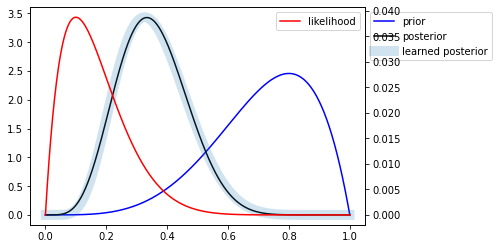

In [5]:
plt.plot(theta_range, gt_prior_dist.prob(theta_range), color="b", label="prior")
plt.plot(theta_range, gt_posterior_dist.prob(theta_range), color="k", label="posterior")
plt.plot(theta_range, jnp.exp(params.log_prob(theta_range)), label='learned posterior', linewidth=10, alpha=0.2)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

likelihood_fun = jax.jit(jax.vmap(lambda x: jnp.exp(jnp.sum(dist.Bernoulli(probs=x).log_prob(tosses)))))
plt.gca().twinx().plot(theta_range, likelihood_fun(theta_range), label="likelihood", color="r");
plt.legend();

### KL divergence between closed-form posterior and learned posterior

In [6]:
key = jax.random.PRNGKey(123)
kl_divergence(key, gt_posterior_dist, params, n_samples=1)

ValueError: Attempt to convert a value (<object object at 0x7f4d0c4e1940>) with an unsupported type (<class 'object'>) to a Tensor.